# Digit Recognizer

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.



## Getting the data

`kaggle-cli` needs to be used to download data on `Google Colab`.


In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

In [0]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c digit-recognizer

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls

'kaggle (1).json'   sample_data		    test.csv
 kaggle.json	    sample_submission.csv   train.csv


## Preprocessing

### Importing libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
import tensorflow as tf

### Importing data

In [0]:
dataset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

features = dataset.drop(['label'], axis = 1).to_numpy()
labels = dataset['label'].to_numpy()

test_features = testset.to_numpy()

### Understanding data

#### Features

In [9]:
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
print("Features:")
print("Shape:", features.shape)
print("Max:", features.max())
print("Min:", features.min())

Features:
Shape: (42000, 784)
Max: 255
Min: 0


#### Labels

In [11]:
labels

array([1, 0, 1, ..., 7, 6, 9])

In [12]:
print("Labels:")
print("Shape:", labels.shape)
print("Max:", labels.max())
print("Min:", labels.min())

Labels:
Shape: (42000,)
Max: 9
Min: 0


#### Constants

In [0]:
FEATURES_SIZE = 42000
NUM_PARAMETERS = 784

#### Visualization

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


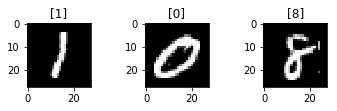

In [14]:
for i in range(6, 9):
  random_index = np.random.randint(0, FEATURES_SIZE, 1)
  random_image = features[random_index].reshape(28, 28)
  plt.subplot(330 + (i + 1))
  plt.imshow(random_image, cmap = 'gist_gray')
  plt.title(labels[random_index])

### Data Cleaning

In [0]:
scaler = MinMaxScaler()
X = scaler.fit_transform(features)

scaler = MinMaxScaler()
X_test = scaler.fit_transform(test_features)

In [0]:
Y = pd.get_dummies(dataset['label']).to_numpy()

## tf: A standard `Neural Network` approach

In [0]:
class datamanager:
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    self.X_size = X.shape[0]
    self.current_index = 0
    
    self.indices = np.arange(FEATURES_SIZE)
    np.random.shuffle(self.indices)
  
  def next_batch(self, size):
    if self.X_size % size != 0:
      raise NameError('Make sure size of dataset is divisible'
                      'by the passed parameter.')
      return 0
    
    sample_X = X[self.current_index: self.current_index + size: 1]
    sample_Y = Y[self.current_index: self.current_index + size: 1]
    
    self.current_index = self.current_index + size
    
    if self.current_index == self.X_size:
      self.current_index = 0
      np.random.shuffle(self.indices)    
    
    return sample_X, sample_Y

In [0]:
mnist = datamanager(X, Y)  

`y = mx + b`

In [0]:
x = tf.placeholder(tf.float32, shape = [None, NUM_PARAMETERS])

In [0]:
m = tf.Variable(tf.zeros([NUM_PARAMETERS, 10]))
b = tf.Variable(tf.zeros([10]))

In [0]:
y = tf.matmul(x, m) + b

In [0]:
y_true = tf.placeholder(tf.float32, shape = [None, 10])

In [23]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y))

W0809 12:42:24.893069 139685029660544 deprecation.py:323] From <ipython-input-23-ba5db817a4be>:1: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5)
train = optimizer.minimize(cross_entropy)

In [0]:
init = tf.global_variables_initializer()

In [26]:
with tf.Session() as sess:
  sess.run(init)
  
  for step in range(20001):
    
    batch_X, batch_Y = mnist.next_batch(100)
    
    sess.run(train, feed_dict = {x: batch_X, y_true: batch_Y})
    
    if step % 1000 == 0:

      correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_true, 1))

      acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

      print("Epoch:", step, ", Training Set Accuracy: ",
            sess.run(acc, feed_dict = {x: X, y_true: Y}))
  
#  print("Evaluating Test Set")
#  pred = tf.argmax(y, axis = 1)
#  submission = sess.run(pred, feed_dict = {x: X_test})

Epoch: 0 , Training Set Accuracy:  0.43111905
Epoch: 1000 , Training Set Accuracy:  0.91657144
Epoch: 2000 , Training Set Accuracy:  0.9262619
Epoch: 3000 , Training Set Accuracy:  0.9267619
Epoch: 4000 , Training Set Accuracy:  0.931
Epoch: 5000 , Training Set Accuracy:  0.92497617
Epoch: 6000 , Training Set Accuracy:  0.9330238
Epoch: 7000 , Training Set Accuracy:  0.9325714
Epoch: 8000 , Training Set Accuracy:  0.9321905
Epoch: 9000 , Training Set Accuracy:  0.9329048
Epoch: 10000 , Training Set Accuracy:  0.9327857
Epoch: 11000 , Training Set Accuracy:  0.9338095
Epoch: 12000 , Training Set Accuracy:  0.93090475
Epoch: 13000 , Training Set Accuracy:  0.9348095
Epoch: 14000 , Training Set Accuracy:  0.9294762
Epoch: 15000 , Training Set Accuracy:  0.93666667
Epoch: 16000 , Training Set Accuracy:  0.9331667
Epoch: 17000 , Training Set Accuracy:  0.9355238
Epoch: 18000 , Training Set Accuracy:  0.93733335
Epoch: 19000 , Training Set Accuracy:  0.93688095
Epoch: 20000 , Training Set Ac

### We can improve on this



## tf: A standard `Convolutional Neural Network` approach



### Helper Functions

#### Init Weights

In [0]:
def init_weights(weight_shape):
  init_random_dist = tf.truncated_normal(weight_shape, stddev = 0.1)
  return tf.Variable(init_random_dist)

#### Init Bias

In [0]:
def init_bias(bias_shape):
  init_bias_vals = tf.constant(0.1, shape = bias_shape)
  return tf.Variable(init_bias_vals)

#### Conv2D

In [0]:
def conv2d(x, W):
  # x --> [batch, H, W, Channels]
  # W --> [filter H, filter W, Channels IN, Channels OUT]
  
  return tf.nn.conv2d(x,
                      W,
                      strides = [1, 1, 1, 1],
                      padding = 'SAME')

#### Pooling

In [0]:
def max_pool_2by2(x):
  # x --> [batch, H, W, Channels]
  return tf.nn.max_pool(x,
                        ksize = [1, 2, 2, 1],
                        strides= [1, 2, 2, 1],
                        padding = 'SAME')

#### Convolutional Layer

In [0]:
def convolutional_layer(input_x, shape):
  W = init_weights(shape)
  b = init_bias([shape[3]])
  return tf.nn.relu(conv2d(input_x, W) + b)

#### Normal Layer

In [0]:
def normal_full_layer(input_layer, size):
  input_size = int(input_layer.get_shape()[1])
  W = init_weights([input_size, size])
  b = init_bias([size])
  return tf.matmul(input_layer, W) + b

### Making the Model

In [0]:
x = tf.placeholder(tf.float32, shape = [None, NUM_PARAMETERS])

In [0]:
y_true = tf.placeholder(tf.float32, shape = [None, 10])

In [0]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [0]:
conv1 = convolutional_layer(x_image, shape = [5, 5, 1, 32])
pool1 = max_pool_2by2(conv1)

In [0]:
conv2 = convolutional_layer(pool1, shape = [5, 5, 1, 64])
pool2 = max_pool_2by2(conv2)

In [0]:
conv2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
full_layer = tf.nn.relu(normal_full_layer(conv2_flat, 1024))

In [0]:
prob = tf.placeholder(tf.float32)
dropout = tf.nn.dropout(full_layer, rate = prob)

In [0]:
y_pred = normal_full_layer(dropout, 10)

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true,
                                                                        logits = y_pred))

In [0]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train = optimizer.minimize(cross_entropy)

In [0]:
init = tf.global_variables_initializer()

In [0]:
steps = 25000
epoch = 1000
batch_size = 100
hold_prob = 0.6

In [51]:
with tf.Session() as sess:
  
  sess.run(init)
  
  for step in range(steps + 1):
    batch_X, batch_Y = mnist.next_batch(batch_size)
    
    sess.run(train,
             feed_dict = {x: batch_X,
                          y_true: batch_Y,
                          prob: hold_prob})
    
    if step % epoch == 0:
      
      correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))

      acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

      print("Epoch:", step, ", Training Set Accuracy: ",
            sess.run(acc, feed_dict = {x: X, y_true: Y, prob: 0}))
    
  
  print("Evaluating Test Set")
  pred = tf.argmax(y_pred, axis = 1)
  submission = sess.run(pred, feed_dict = {x: X_test,
                                           prob: 0})
      

Epoch: 0 , Training Set Accuracy:  0.1542143
Epoch: 1000 , Training Set Accuracy:  0.9861905
Epoch: 2000 , Training Set Accuracy:  0.9923095
Epoch: 3000 , Training Set Accuracy:  0.9955476
Epoch: 4000 , Training Set Accuracy:  0.99628574
Epoch: 5000 , Training Set Accuracy:  0.9966428
Epoch: 6000 , Training Set Accuracy:  0.99852383
Epoch: 7000 , Training Set Accuracy:  0.9992381
Epoch: 8000 , Training Set Accuracy:  0.9989762
Epoch: 9000 , Training Set Accuracy:  0.99916667
Epoch: 10000 , Training Set Accuracy:  0.99983335
Epoch: 11000 , Training Set Accuracy:  0.9996905
Epoch: 12000 , Training Set Accuracy:  0.9996667
Epoch: 13000 , Training Set Accuracy:  0.9998571
Epoch: 14000 , Training Set Accuracy:  0.99983335
Epoch: 15000 , Training Set Accuracy:  0.9997857
Epoch: 16000 , Training Set Accuracy:  0.9998571
Epoch: 17000 , Training Set Accuracy:  0.9999762
Epoch: 18000 , Training Set Accuracy:  0.99990475
Epoch: 19000 , Training Set Accuracy:  0.9999762
Epoch: 20000 , Training Set

## Saving the Model

In [0]:
ID = np.arange(test_features.shape[0]) + 1

csv = pd.DataFrame({'ImageId': ID,
                    'Label': submission})

csv.to_csv('result.csv', index = False)

In [55]:
!ls

'kaggle (1).json'   result.csv	  sample_submission.csv   train.csv
 kaggle.json	    sample_data   test.csv


In [0]:
from google.colab import files
files.download('result.csv')